In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os as os

#ML Regression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

#ML PCA
from scipy.cluster import hierarchy
import seaborn as sns
from sklearn import decomposition, preprocessing, cluster, tree
import pydotplus
from yellowbrick.cluster.silhouette import SilhouetteVisualizer

# Preprocessing Data

With a more robust dataset obtained in Step 2, we will proceed to clean and generate two base DataFrame to be used in the following steps.

In [ ]:
def preprocessing(df):  

    #drop duplicated columns
    drop_column=[b
    df=df.drop(drop_column,axis=1)
    
    #renaming
    column_names=['author', 'date_recorded', 'views', 'likes', 'title',
       'description_1', 'duration_seg', 'date_released', 'keywords','description_2']
    df.columns=column_names

    #mm
    #MODIFYING COLUMN: date_recorded
    #
    df['date_recorded']= pd.to_datetime(df['date_recorded'], format='%B %Y')
  
    ##separate data into new Column
    list_months=[]
    list_years=[]
    for i in range(df.shape[0]):
        list_months.append(df['date_recorded'][i].month)
        list_years.append(df['date_recorded'][i].year)
    df['date_recorded_year']=list_years
    df['date_recorded_month']=list_months

    #
    #MODIFYING COLUMN: date_released
    #
    column='date_released'
    df[column]= pd.to_datetime(df[column], format='%Y-%m-%d %H:%M:%S')

    ##separate data into new Column
    list_months=[]
    list_years=[]
    list_hours=[]
    list_minutes=[]
    for i in range(df.shape[0]):
        list_months.append(df[column][i].month)
        list_years.append(df[column][i].year)
        list_hours.append(df[column][i].hour)
        list_minutes.append(df[column][i].minute)
    df[column+'_year']=list_years
    df[column+'_month']=list_months
    df[column+'_hour']=list_hours
    df[column+'_minute']=list_minutes

    #
    #MODIFYING COLUMN: 'keywords'
    #
    df_key=df.keywords
    i=0
    df_result=pd.DataFrame()
    ##transforming line into string
    for line in df_key:
        line=(str(line).replace("[","").replace("]","").split(','))
        new_line=[]
        ##removing additional spaces in words and converting the into lower case
        for word in line:
            word=word.lower().replace(' ', '')[1:-1]
            new_line.append(word)
        ##transforming line into string
        new_line=str(new_line).replace("[","").replace("]","")
        ##writting line into dataframe
        df_result.at[i,'keywords2']=new_line
        i=i+1
  
    df=pd.concat([df,df_result], axis=1)

    #drop initial columns
    drop_columns=['date_recorded','date_released', 'keywords']
    df=df.drop(drop_columns, axis=1)
    
    return(df)

In [ ]:
def create_dummies_file(df):
    '''
    This function does: 
    1) convert df.keywords into dummy columns
    2) creates a file called ''in order to manually map new categories from keywords
    '''
    #converting keywords into dummy columns
    df2=df.keywords2.str.get_dummies(',')

    #joining with df
    df=pd.concat([df,df2], axis=1)
    
    #removing 'ted' column
    column_to_drop=df.columns[362]
    df2=df.drop(column_to_drop, axis=1)

    #counting dummies and creating file to rename categories
    dummy_columns=pd.Series(np.arange(15,349,1))[1:]
    df_dummies=df.iloc[:,dummy_columns].sum().reset_index()
    df_dummies.columns=['keyword', 'sum']
    df2=df_dummies.copy()
    (df2
     .groupby(['keyword'])
     .agg({'sum':'sum'})
    )
    df2=df2.sort_values(by='sum', ascending=False)
    cwd=os.getcwd()
    df2.to_csv(cwd+'/keywords.csv')
    return df

In [ ]:
def dummy_data(df):
    '''
    This function takes the keyword_categories.csv file and creates a new dataframe 'df_dummies' to analyze the keywords
    '''
    # cwd=os.getcwd()
    # categories=pd.read_csv(cwd+'/keywords_categories.csv')
    #for github
    categories=pd.read_csv('https://github.com/aaas24/code_library/raw/main/ted_talks/2_preprocessing/keywords_categories.csv')

    #transforming categories
    new_cat=(categories.columns.values.tolist())
    dic={key: None for key in new_cat}

    ##creating dictionary with categories file
    for column in range (0,categories.shape[1]):
        dic_values=[]
        key=new_cat[column]
        for row in range (0,categories.shape[0]):
            value=categories.iloc[row,column]
            if value is np.nan:
                pass
            else:
                value=value.replace(' ', '')[1:-1]
                dic_values.append(value)
        dic.update({key:dic_values})

    ##adding column to df with 
    dummy_columns=pd.concat([df.iloc[:,16:349], df[['likes', 'views']]], axis=1)
    df_dummies=dummy_columns.iloc[:,:-2].sum().reset_index()
    df_dummies.columns=['sub_category', 'num_talks']
    
    #adding categories to subcategories
    list_categories=[]
    for i in range (0, len(set(df_dummies['sub_category']))):
        keyword=df_dummies['sub_category'][i][2:-1]
        ###find category of keyword in dictionary
        for key, value_list in dic.items():
            for x in value_list:
                if keyword==x:
                    category=key
        ###add category to list
        list_categories.append(category)
    
    ##add list_categories to df
    df_dummies['category']=list_categories

    #add num likes and views
    list_likes=[]
    list_views=[]
    for row in range (0,df_dummies.shape[0]):
        subcategory=df_dummies.iloc[row,0]
        df2=dummy_columns[[subcategory,'likes','views']]
        df2.columns=['A', 'likes','views']
        df3=(df2
             .query('A>0')
             .groupby('A')
             .agg({'likes': ['sum'], 'views':['sum']})
            )
        
        list_likes.append(df3.iloc[0,0])
        list_views.append(df3.iloc[0,1])
    #add lists to df_dummies
    df_dummies['likes']=list_likes
    df_dummies['views']=list_views
    return df_dummies

In [ ]:
def main():
    #load data
    raw_data=pd.read_csv('https://github.com/aaas24/code_library/raw/main/ted_talks/1_raw_data/final_raw_data.csv')
    df=raw_data.copy()

    #clean data
    df=preprocessing(df)
    df=create_dummies_file(df)
    df_dummies=dummy_data(df)
    return(df, df_dummies)
  


In [ ]:
if __name__ == '__main__':
  main()

In [ ]:
df=main()[0]
df.head(5)

,author,views,likes,title,description_1,duration_seg,description_2,date_recorded_year,date_recorded_month,date_released_year,...,'water','weather','windenergy','women','womeninbusiness','work','work-lifebalance','writing','youth','ted'
0,Ozawa Bineshi Albert,404000,12000,Climate action needs new frontline leadership,"""We can't rely on those who created climate ch...",834,"""We can't rely on those who created climate ch...",2021,12,2022,...,0,0,0,0,0,0,0,0,0,1
1,Sydney Iaukea,214000,6400,The dark history of the overthrow of Hawaii,"""On January 16th, 1895, two men arrived at Lil...",0,"""On January 16th, 1895, two men arrived at Lil...",2022,2,2022,...,0,0,0,1,0,0,0,0,0,1
2,Martin Reeves,412000,12000,Why play is essential for business,"""To thrive in today's competitive economy, you...",665,"""To thrive in today's competitive economy, you...",2021,9,2022,...,0,0,0,0,0,1,0,0,0,1
3,James K. Thornton,427000,12000,Why is China appointing judges to combat clima...,"""Why is China appointing thousands of judges t...",695,"""Why is China appointing thousands of judges t...",2021,10,2022,...,0,0,0,0,0,0,0,0,0,1
4,Mahendra Singhi,2400,72,Cement's carbon problem -- and 2 ways to fix it,"""Cement is vital to modernizing all kinds of i...",671,"""Cement is vital to modernizing all kinds of i...",2021,10,2022,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
df_dummies=main()[1]
df_dummies.head(5)

,sub_category,num_talks,category,likes,views
0,'3dprinting',9,technology,201574,6655100
1,'activism',352,values & emotions,21752759,714057797
2,'addiction',20,health,1870500,60982000
3,'africa',197,global,9097799,299541000
4,'aging',93,society,8152092,269034199


# Data Exploration

## PCA - Visualize High Dimension Data

In [ ]:
df.head(3)

,author,views,likes,title,description_1,duration_seg,description_2,date_recorded_year,date_recorded_month,date_released_year,...,'water','weather','windenergy','women','womeninbusiness','work','work-lifebalance','writing','youth','ted'
0,Ozawa Bineshi Albert,404000,12000,Climate action needs new frontline leadership,"""We can't rely on those who created climate ch...",834,"""We can't rely on those who created climate ch...",2021,12,2022,...,0,0,0,0,0,0,0,0,0,1
1,Sydney Iaukea,214000,6400,The dark history of the overthrow of Hawaii,"""On January 16th, 1895, two men arrived at Lil...",0,"""On January 16th, 1895, two men arrived at Lil...",2022,2,2022,...,0,0,0,1,0,0,0,0,0,1
2,Martin Reeves,412000,12000,Why play is essential for business,"""To thrive in today's competitive economy, you...",665,"""To thrive in today's competitive economy, you...",2021,9,2022,...,0,0,0,0,0,1,0,0,0,1


In [ ]:
#dropping categorical columns
df_model=df.drop(['author','title','description_1', 'description_2', 'keywords2'], axis=1).iloc[:,:9]
df_model.head(3)

,views,likes,duration_seg,date_recorded_year,date_recorded_month,date_released_year,date_released_month,date_released_hour,date_released_minute
0,404000,12000,834,2021,12,2022,2,9,41
1,214000,6400,0,2022,2,2022,2,10,13
2,412000,12000,665,2021,9,2022,2,9,51


In [ ]:
X = df_model
std = preprocessing.StandardScaler()
X_std = pd.DataFrame(std.fit_transform(X), columns=X.columns)
X_std

,views,likes,duration_seg,date_recorded_year,date_recorded_month,date_released_year,date_released_month,date_released_hour,date_released_minute
0,-0.464984,-0.470418,0.264675,1.309927,1.591529,1.446482,-1.209561,-0.513606,0.637580
1,-0.518216,-0.522405,-1.536697,1.528134,-1.311085,1.446482,-1.209561,-0.256235,-0.721544
2,-0.462743,-0.470418,-0.100352,1.309927,0.720745,1.446482,-1.209561,-0.513606,1.122981
3,-0.458540,-0.470418,-0.035554,1.309927,1.011006,1.446482,-1.209561,-0.513606,0.831740
4,-0.577500,-0.581151,-0.087392,1.309927,1.011006,1.446482,-1.209561,-0.513606,0.491959
...,...,...,...,...,...,...,...,...,...
5435,3.624367,3.670033,0.605942,-1.963185,-1.311085,-2.359267,0.221125,2.060102,-0.818624
5436,19.594017,18.913574,0.977448,-1.963185,-1.311085,-2.359267,-0.065012,2.060102,-0.818624
5437,0.234319,0.235130,0.873772,-1.963185,-1.311085,-2.359267,-0.065012,2.060102,-0.818624
5438,-0.017834,-0.024809,0.873772,-1.963185,-1.311085,-2.359267,-0.065012,2.060102,-0.818624


In [ ]:
pca = decomposition.PCA()
pca_X = pd.DataFrame(pca.fit_transform(X_std), columns=[f'PC{i+1}' for i in range(len(X.columns))])
pca_X

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
0,-2.353050,0.640153,0.284316,-0.603109,0.929410,-1.291875,0.239075,-0.030687,0.003502
1,-1.731059,0.280292,-1.858844,-1.413271,-1.016366,0.526591,1.118925,-0.092696,0.003599
2,-2.317451,0.717196,0.179404,-1.127605,0.461949,-0.588923,-0.108814,-0.019253,0.005456
3,-2.306187,0.672507,0.132764,-0.911835,0.568249,-0.854332,0.092875,-0.021647,0.008290
4,-2.314708,0.465819,-0.036364,-0.827110,0.516955,-0.914731,0.337036,-0.014700,0.002438
...,...,...,...,...,...,...,...,...,...
5435,5.811723,2.436950,-1.161030,0.723981,0.493394,0.399537,-0.999472,-0.290728,-0.032605
5436,17.210024,21.196511,-2.006792,2.509708,1.380970,-0.442098,-0.713892,-0.125093,0.480695
5437,3.392499,-1.689732,-0.931235,0.032325,0.647645,0.457366,-0.976476,-0.341491,-0.000921
5438,3.206750,-1.997994,-0.916213,-0.001125,0.638960,0.469690,-0.979716,-0.344335,0.004586


In [ ]:
#variance or relevance of PCAs. In this case the first 3 hold ~50% of representation of the data
pca.explained_variance_ratio_


array([2.61155893e-01, 2.09808747e-01, 1.27262369e-01, 1.19521228e-01,
       1.01198399e-01, 9.06161518e-02, 8.05875806e-02, 9.81195975e-03,
       3.76713129e-05])

In [ ]:
# Components
# First component is .36 * Views + .36 * likes + 0.19 * Dur ... etc
pca.components_[0]

array([ 0.36279544,  0.36266011,  0.19279606, -0.52126245, -0.25986923,
       -0.53505052, -0.01655183,  0.10777476, -0.2495432 ])

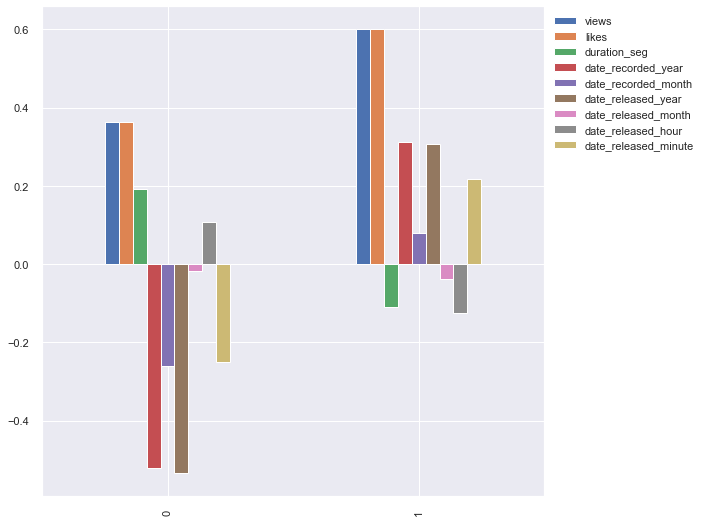

In [138]:
# What columns make up the components 1 & 2?
# 1 - Views & Likes
# 2 - Recorded & Released Year
(pd.DataFrame(pca.components_, columns=X.columns)
 .iloc[:2]
 .plot.bar()
 .legend(bbox_to_anchor=(1,1)))

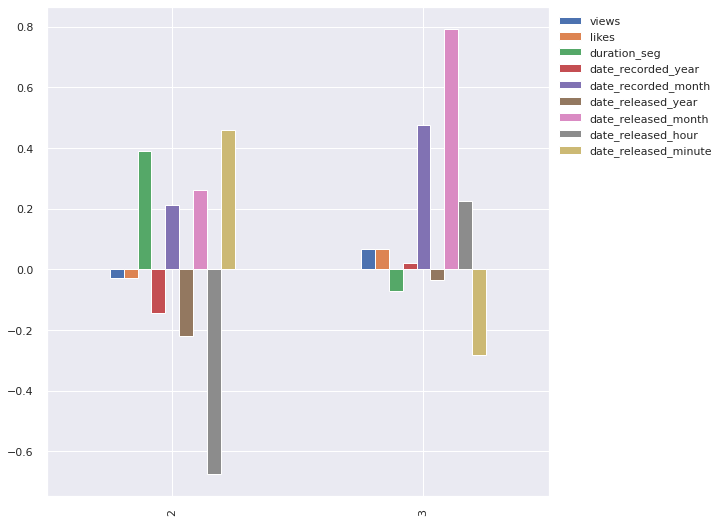

In [ ]:
# What columns make up the components 3 & 4?
(pd.DataFrame(pca.components_, columns=X.columns)
 .iloc[2:4]
 .plot.bar()
 .legend(bbox_to_anchor=(1,1)))

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

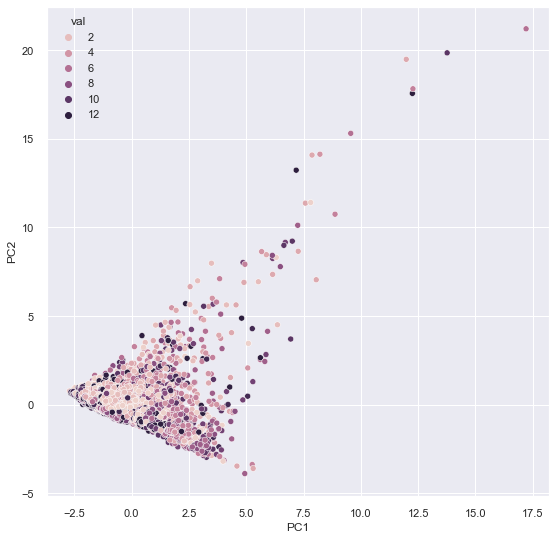

In [139]:
# Plot with Seaborn
x='PC1'
y='PC2'
val='date_released_month'
sns.scatterplot(x=x, y=y, 
                data=pca_X.assign(val=X[val]), 
                hue='val')

## Clustering

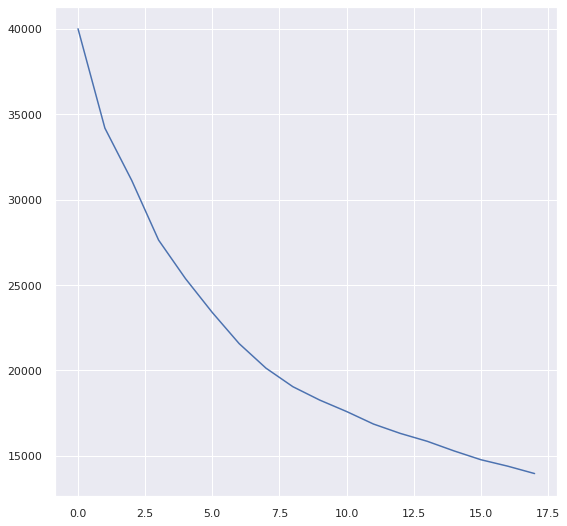

In [ ]:
inerts = []
for i in range(2, 20):
    k = cluster.KMeans(n_clusters=i, random_state=42)
    k.fit(X_std)
    inerts.append(k.inertia_)
    
pd.Series(inerts).plot()

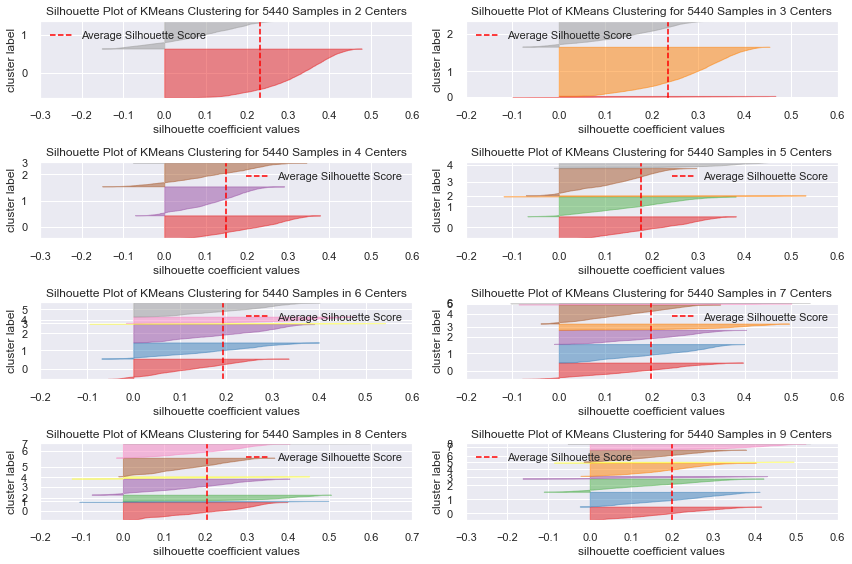

In [141]:
start, end = 2, 10
cols = 2
rows = ((end - start) // cols)
fix, axes = plt.subplots(rows, cols, figsize=(12,8))
axes = axes.reshape(cols * rows)
for i, k in enumerate(range(start, end), 0):
    ax = axes[i]
    sil = SilhouetteVisualizer(cluster.KMeans(n_clusters=k, random_state=42), ax=ax)
    sil.fit(X_std)
    sil.finalize()
plt.tight_layout()

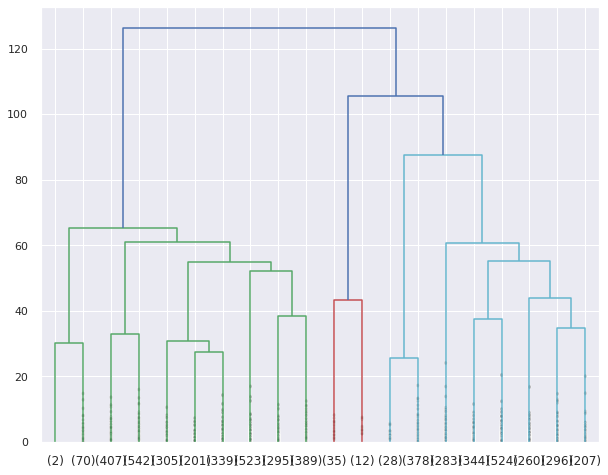

In [ ]:
# Try another mechanism
fig, ax = plt.subplots(figsize=(10,8))
hierarchy.dendrogram(hierarchy.linkage(X_std, method='ward'),
                    truncate_mode='lastp', p=20, show_contracted=True)
pass  # here to hide return value of above

In [ ]:
# going to choose 4 clusters
k9 = cluster.KMeans(n_clusters=4, random_state=42)
k9.fit(X_std)
labels = k9.predict(X_std)

In [ ]:
labels

array([1, 1, 1, ..., 2, 2, 2], dtype=int32)

In [ ]:
X.assign(label=labels)

,views,likes,duration_seg,date_recorded_year,date_recorded_month,date_released_year,date_released_month,date_released_hour,date_released_minute,label
0,404000,12000,834,2021,12,2022,2,9,41,1
1,214000,6400,0,2022,2,2022,2,10,13,1
2,412000,12000,665,2021,9,2022,2,9,51,1
3,427000,12000,695,2021,10,2022,2,9,45,1
4,2400,72,671,2021,10,2022,2,9,38,1
...,...,...,...,...,...,...,...,...,...,...
5435,15000000,458000,992,2006,2,2006,7,19,11,3
5436,72000000,2100000,1164,2006,2,2006,6,19,11,3
5437,2900000,88000,1116,2006,2,2006,6,19,11,2
5438,2000000,60000,1116,2006,2,2006,6,19,11,2


In [ ]:
(X.assign(label=labels)
  .groupby('label')
  .agg(['mean', 'var'])
  .T
)

label                                 0             1             2  \
views                mean  1.579249e+06  1.829965e+06  1.887791e+06   
                     var   2.991364e+12  4.134593e+12  3.745353e+12   
likes                mean  4.808912e+04  5.563381e+04  5.721366e+04   
                     var   2.814619e+09  3.858025e+09  3.489601e+09   
duration_seg         mean  6.350369e+02  6.455351e+02  8.631271e+02   
                     var   1.554876e+05  2.034898e+05  2.523900e+05   
date_recorded_year   mean  2.017660e+03  2.017270e+03  2.009742e+03   
                     var   5.702002e+00  6.409831e+00  1.294749e+01   
date_recorded_month  mean  8.097666e+00  6.384876e+00  5.200713e+00   
                     var   7.532558e+00  1.283434e+01  1.070241e+01   
date_released_year   mean  2.018230e+03  2.018567e+03  2.010543e+03   
                     var   4.012342e+00  3.833456e+00  5.029017e+00   
date_released_month  mean  9.693489e+00  3.415414e+00  6.343824e+00   
                     var   2.869116e+00  3.324437e+00  1.088053e+01   
date_released_hour   mean  1.113759e+01  1.091032e+01  1.094240e+01   
                     var   6.582163e+00  7.480315e+00  3.244410e+01   
date_released_minute mean  3.214742e+01  3.283713e+01  1.764311e+01   
                     var   3.840004e+02  3.897591e+02  3.564008e+02   

label                                 3  
views                mean  2.616923e+07  
                     var   1.764240e+14  
likes                mean  7.927385e+05  
                     var   1.495301e+11  
duration_seg         mean  7.886462e+02  
                     var   1.738138e+05  
date_recorded_year   mean  2.012277e+03  
                     var   1.195337e+01  
date_recorded_month  mean  5.215385e+00  
                     var   1.101538e+01  
date_released_year   mean  2.013262e+03  
                     var   1.528990e+01  
date_released_month  mean  5.630769e+00  
                     var   1.079904e+01  
date_released_hour   mean  1.152308e+01  
                     var   2.059712e+01  
date_released_minute mean  2.761538e+01  
                     var   3.713341e+02

In [ ]:
# how many in each cluster?
pd.Series(labels).value_counts().sort_index()

0    1628
1    2063
2    1684
3      65
dtype: int64

In [142]:
# Add coloring to aid impact to clusters
(X.assign(label=labels)
  .groupby('label')
  .mean()
  .T
 .style.background_gradient(cmap='RdBu', axis=1)
)

label,0,1,2,3
views,1579248.831081,1829964.674746,1887790.967933,26169230.769231
likes,48089.123464,55633.806108,57213.657957,792738.461538
duration_seg,635.036855,645.535143,863.127078,788.646154
date_recorded_year,2017.660319,2017.270480,2009.741686,2012.276923
date_recorded_month,8.097666,6.384876,5.200713,5.215385
date_released_year,2018.229730,2018.566651,2010.543349,2013.261538
date_released_month,9.693489,3.415414,6.343824,5.630769
date_released_hour,11.137592,10.910325,10.942399,11.523077
date_released_minute,32.147420,32.837130,17.643112,27.615385


### Clusters
* 0 - Newer videos released in fall
* 1 - Newer videos released in earlier in the year
* 2 - Older videos, longer duration in seg
* 3 - Highest views & likes

In [ ]:
# describe a column for each label
(X.assign(label=labels)
  .groupby('label')
  .date_recorded_year
  .describe()
)

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
0,1628.0,2017.660319,2.387886,2009.0,2016.0,2018.0,2020.0,2021.0
1,2063.0,2017.270480,2.531764,2009.0,2015.0,2017.0,2019.0,2022.0
2,1684.0,2009.741686,3.598263,1970.0,2009.0,2010.0,2012.0,2021.0
3,65.0,2012.276923,3.457364,2004.0,2010.0,2013.0,2015.0,2019.0


In [ ]:
# describe a label in a cluster
(X.assign(label=labels)
 .query('label == 0')
 .describe()
)

,views,likes,duration_seg,date_recorded_year,date_recorded_month,date_released_year,date_released_month,date_released_hour,date_released_minute,label
count,1.628000e+03,1628.000000,1628.000000,1628.000000,1628.000000,1628.000000,1628.000000,1628.000000,1628.000000,1628.0
mean,1.579249e+06,48089.123464,635.036855,2017.660319,8.097666,2018.229730,9.693489,11.137592,32.147420,0.0
std,1.729556e+06,53052.986698,394.319134,2.387886,2.744551,2.003083,1.693846,2.565573,19.595928,0.0
min,1.200000e+03,37.000000,0.000000,2009.000000,1.000000,2010.000000,5.000000,5.000000,0.000000,0.0
25%,4.147500e+05,12000.000000,327.750000,2016.000000,6.000000,2017.000000,8.000000,9.000000,12.000000,0.0
50%,1.300000e+06,41000.000000,612.000000,2018.000000,9.000000,2018.000000,10.000000,10.000000,36.000000,0.0
75%,1.900000e+06,59000.000000,831.000000,2020.000000,10.000000,2020.000000,11.000000,14.000000,50.000000,0.0
max,1.400000e+07,435000.000000,4125.000000,2021.000000,12.000000,2021.000000,12.000000,20.000000,59.000000,0.0


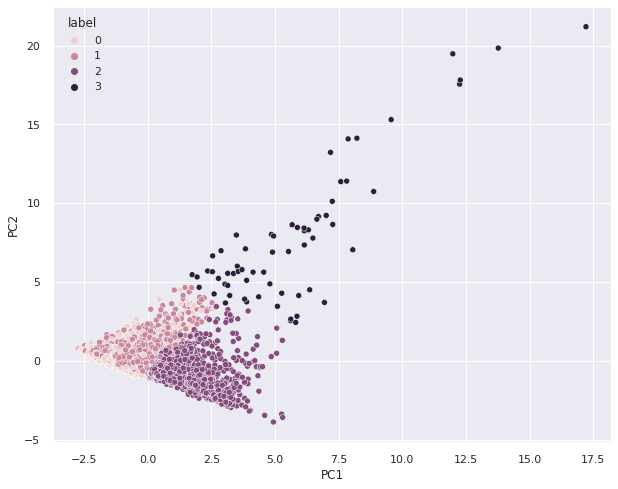

In [ ]:
# Plot with Seaborn
cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
fig, ax = plt.subplots(figsize=(10,8))
sns.scatterplot(x='PC1', y='PC2', 
                data=pca_X.assign(label=labels),
                cmap='Pastel',
                hue='label', ax=ax)

In [ ]:
from bokeh.io import output_notebook
from bokeh import models, palettes, transform
from bokeh.plotting import figure, show

def bokeh_scatter(
    x,
    y,
    data,
    hue=None,
    label_cols=None,
    size=None,
    legend=None,
    alpha=0.5,
):
    """
    x - x column name to plot
    y - y column name to plot
    data - pandas dataframe
    hue - column name to color by (numeric)
    legend - column name to label by
    label_cols - columns to use in tooltip (None all in dataframe)
    size - size of points in screen space unigs
    alpha - transparency
    """
    output_notebook()
    circle_kwargs = {}
    if legend:
        circle_kwargs["legend"] = legend
    if size:
        circle_kwargs["size"] = size
    if hue:
        color_seq = data[hue]
        mapper = models.LinearColorMapper(
            palette=palettes.viridis(256),
            low=min(color_seq),
            high=max(color_seq),
        )
        circle_kwargs[
            "fill_color"
        ] = transform.transform(hue, mapper)
    ds = models.ColumnDataSource(data)
    if label_cols is None:
        label_cols = data.columns
    tool_tips = sorted(
        [
            (x, "@{}".format(x))
            for x in label_cols
        ],
        key=lambda tup: tup[0],
    )
    hover = models.HoverTool(
        tooltips=tool_tips
    )
    fig = figure(
        tools=[
            hover,
            "pan",
            "zoom_in",
            "zoom_out",
            "reset",
        ],
        toolbar_location="below",
    )

    fig.circle(
        x,
        y,
        source=ds,
        alpha=alpha,
        **circle_kwargs
    )
    show(fig)
    return fig

res = bokeh_scatter("PC1","PC2", 
                    data=pd.concat([pca_X, X], axis=1).assign(label=labels), hue='label', size=10,
                    label_cols=list(X.columns)+['label'],
                   legend='label')

## Exploring

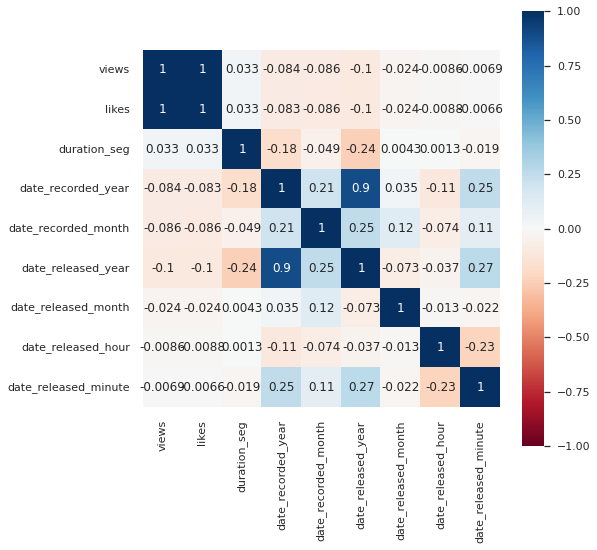

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(df_graph.corr(), cmap='RdBu', vmin=-1, vmax=1, annot=True, square=True, ax=ax)

## Exploring: date recorded

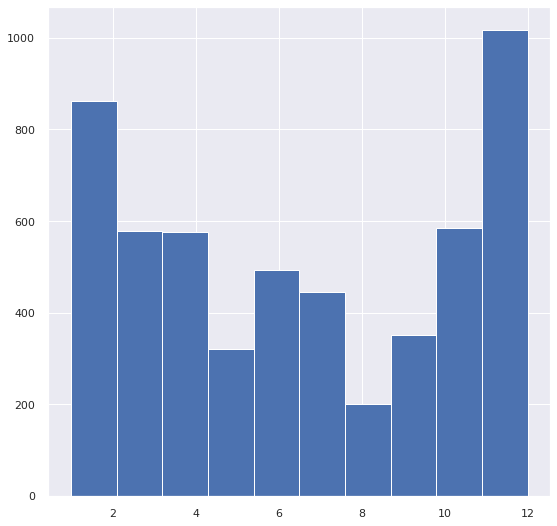

In [ ]:
df_graph=df[df.date_recorded_year>2000]
df_graph.date_recorded_month.hist()

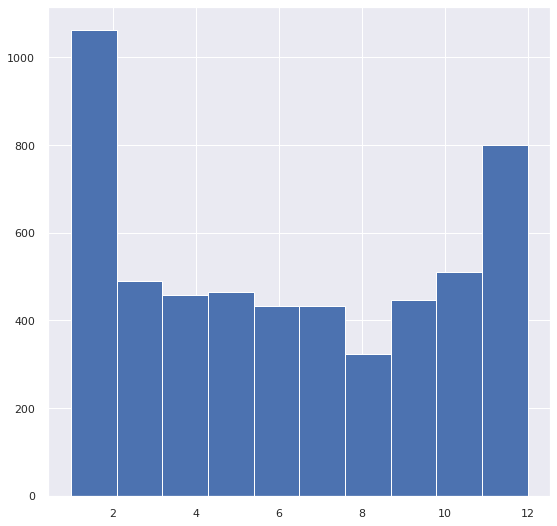

In [ ]:
df_graph.date_released_month.hist()

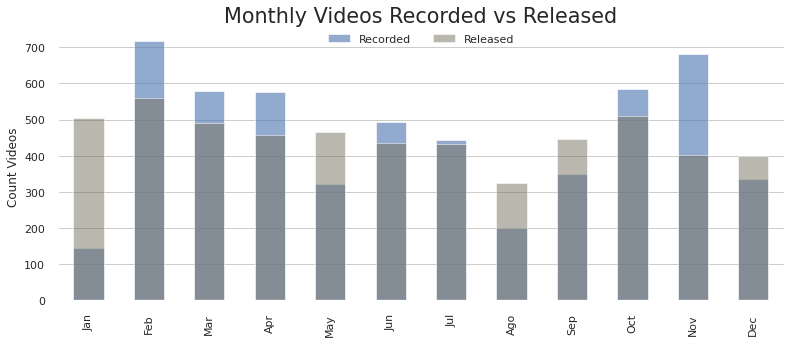

In [ ]:
#improving graph

data=df[df.date_recorded_year>2000]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(13,5), sharex=True)

#plotting first histogram
ax=(data
    .groupby(['date_recorded_month'])
    .likes
    .count()
    .plot(x='date_recorded_month', kind = 'bar',alpha=0.6, ax=ax,) 
)
#plotting second hidtogram
ax=(data
    .groupby(['date_released_month'])
    .likes
    .count()
    .plot(x='date_released_month', kind = 'bar',alpha=0.5, ax=ax, color='#76725e') 
)
#improving labes
ax.set_xticks(ticks=range(0,12,1))  
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dec'])
ax.set_xlabel('')
ax.set_ylabel('Count Videos ')
#styling grid, leyend and title
plt.title('Monthly Videos Recorded vs Released', ha='center', fontsize='xx-large')
plt.legend(["Recorded", "Released"], loc='upper center',ncol=2, bbox_to_anchor=(0.5, 1.1), borderaxespad=2.6, facecolor="white")
ax.set_facecolor("white")
plt.grid(axis='y', color='black', alpha=.2)

Text(0.5, 1.0, 'Number of Videos Released by year')

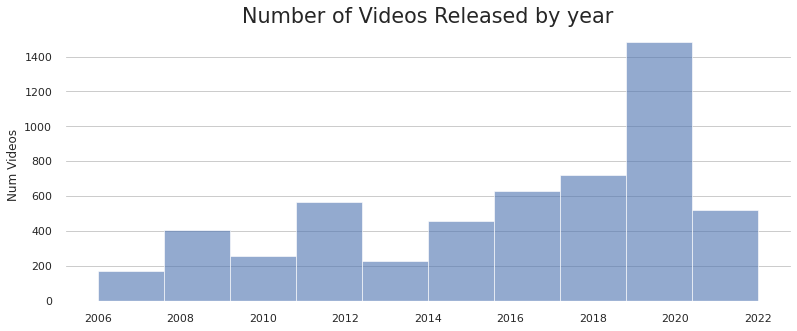

In [ ]:
title='Number of Videos Released by Year'
y_label='Num Videos'

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(13,5), sharex=True)
ax=df.date_released_year.hist(alpha=0.6)
plt.plot(ax=ax)
plt.grid(axis='x')
ax.set_facecolor("white")
ax.set_ylabel(y_label)
plt.grid(axis='y', color='black', alpha=.2)
plt.title(title, ha='center', fontsize='xx-large')

Text(0.5, 1.0, 'Number of Videos Recorded by year')

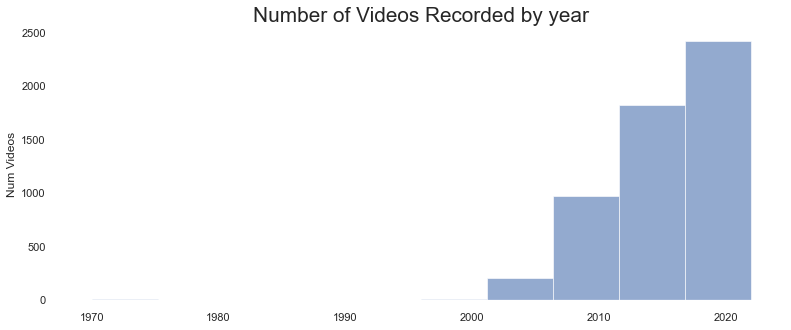

In [144]:
title='Number of Videos Recorded per Year'
y_label='Num Videos'

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(13,5), sharex=True)
ax=df.date_recorded_year.hist(alpha=0.6)
plt.plot(ax=ax)
plt.grid(axis='x')
ax.set_facecolor("white")
ax.set_ylabel(y_label)
plt.grid(axis='y', color='black', alpha=.2)
plt.title(title, ha='center', fontsize='xx-large')

Text(0.5, 1.0, 'Most Videos were Recorded Between 2012-2020')

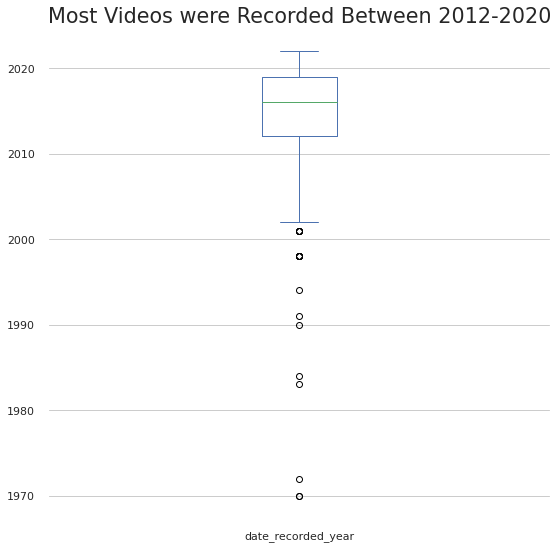

In [ ]:
# Are there outliers
title='Most Videos were Recorded Between 2012-2020'
ax=df.date_recorded_year.plot.box()
plt.plot(ax=ax)
plt.grid(axis='x')
ax.set_facecolor("white")
plt.grid(axis='y', color='black', alpha=.2)
plt.title(title, ha='center', fontsize='xx-large')

In [ ]:
df_graph=df[df.date_recorded_year<2000]


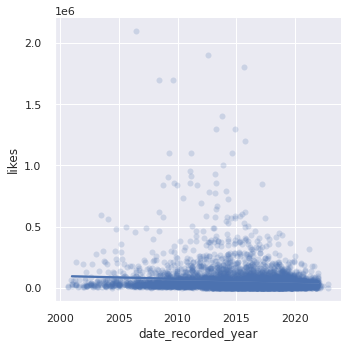

In [ ]:
#removing outliyers
df_graph=df[df.date_recorded_year>2000]
sns.lmplot(x='date_recorded_year', y='likes', data=df_graph, x_jitter=1, scatter_kws={'alpha':.2})

## Exploring: duration of videos

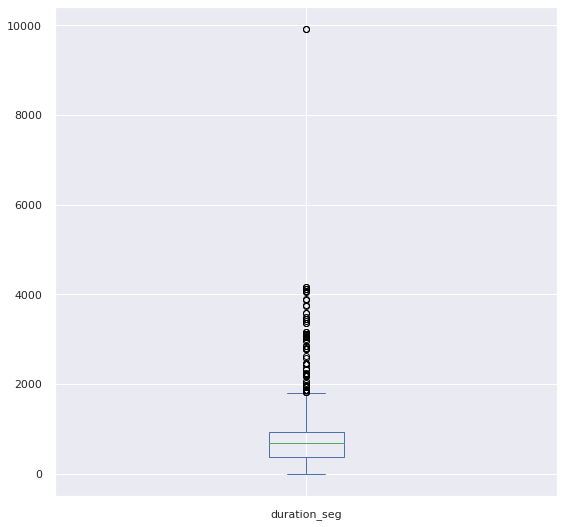

In [ ]:
# Are there outliers
df.duration_seg.plot.box()

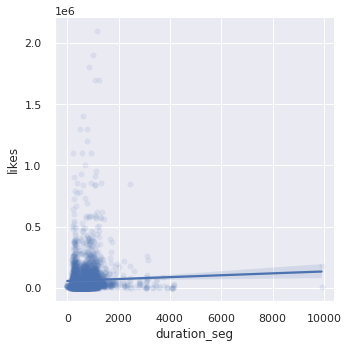

In [ ]:
#removing outliyers
df_graph=df[df.date_recorded_year>2000]
sns.lmplot(x='duration_seg', y='likes', data=df_graph, x_jitter=1, scatter_kws={'alpha':.1})

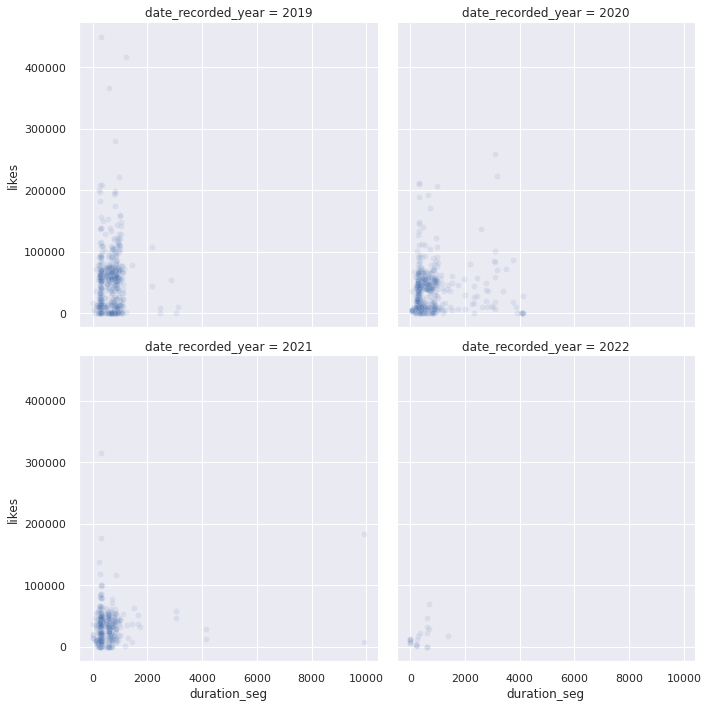

In [ ]:
#Insight: during pandemic years (2020-2021) 
df_graph=df[df.date_recorded_year>2018]
sns.relplot(x='duration_seg', y='likes', data=df_graph, col='date_recorded_year', col_wrap=2, alpha=.1)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9b8a4a6c90>,
      dtype=object)

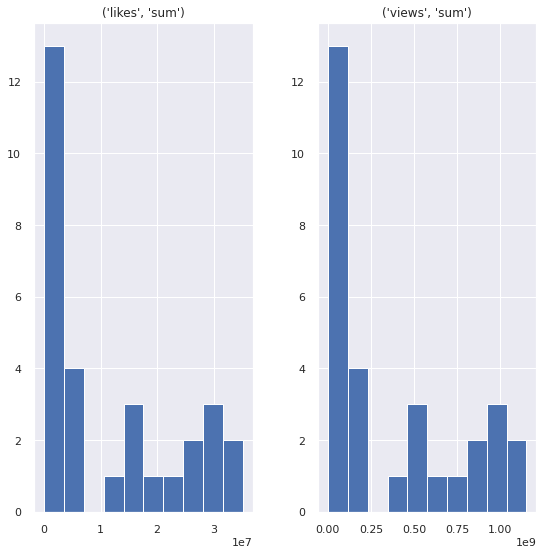

In [ ]:
df_graph = pd.pivot_table(data=df, 
               index=['date_recorded_year'], 
               values=['likes','views'], 
               aggfunc={'likes':[np.sum],'views':np.sum}
        )
df_graph.hist()

In [ ]:
not_dummy_columns=pd.Series(np.arange(0,14,1))
df_graph=df.iloc[:,not_dummy_columns].reset_index().drop('index', axis=1)
df_graph.corr()

,views,likes,duration_seg,date_recorded_year,date_recorded_month,date_released_year,date_released_month,date_released_hour,date_released_minute
views,1.000000,0.999661,0.032513,-0.083600,-0.085797,-0.101028,-0.024079,-0.008555,-0.006850
likes,0.999661,1.000000,0.032510,-0.083206,-0.086190,-0.100779,-0.023818,-0.008762,-0.006632
duration_seg,0.032513,0.032510,1.000000,-0.178443,-0.048921,-0.235843,0.004286,0.001337,-0.019144
date_recorded_year,-0.083600,-0.083206,-0.178443,1.000000,0.207671,0.897664,0.034764,-0.107005,0.250998
date_recorded_month,-0.085797,-0.086190,-0.048921,0.207671,1.000000,0.250865,0.119744,-0.073505,0.107123
date_released_year,-0.101028,-0.100779,-0.235843,0.897664,0.250865,1.000000,-0.073472,-0.037315,0.272284
date_released_month,-0.024079,-0.023818,0.004286,0.034764,0.119744,-0.073472,1.000000,-0.012557,-0.021944
date_released_hour,-0.008555,-0.008762,0.001337,-0.107005,-0.073505,-0.037315,-0.012557,1.000000,-0.226456
date_released_minute,-0.006850,-0.006632,-0.019144,0.250998,0.107123,0.272284,-0.021944,-0.226456,1.000000


## Exploring: Keywords categories

In [ ]:
df_dummies=main()[1]
df_dummies.head(3)

,sub_category,num_talks,category,likes,views
0,'3dprinting',9,technology,201574,6655100
1,'activism',352,values & emotions,21752759,714057797
2,'addiction',20,health,1870500,60982000


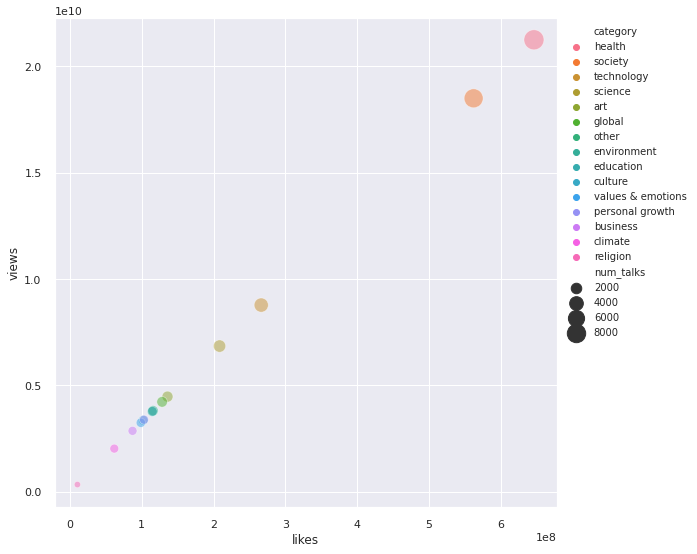

In [ ]:
df_graph=(
            df_dummies.
            groupby(['category'])
            .agg({'likes':['sum'],'views':['sum'], 'num_talks':['sum']})
            
)
df_graph.columns=['likes', 'views', 'num_talks']
df_graph=df_graph.sort_values(by=['num_talks'], ascending=False)

#plot
sns.scatterplot(data=df_graph, x="likes", y="views", size="num_talks", legend=True, hue='category', alpha=0.5, sizes=(40, 400)) 
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize=10)
sns.axes_style({
    'axes.facecolor': 'white',
    'axes.edgecolor': 'black',
    'axes.grid': False,
    'figure.facecolor': 'white',
     'grid.color': 'white',
     'grid.linestyle': '-',
     'font.sans-serif': 'Arial',
     'grid.color': '#ffffff'

})
sns.set(rc={"figure.figsize":(9 , 9)}) #(width,height)
plt.show()

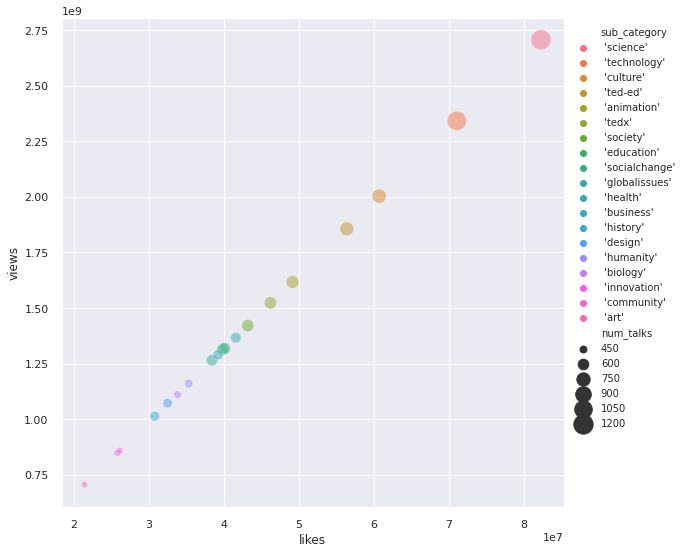

In [ ]:
df_graph=(
            df_dummies.
            groupby(['sub_category'])
            .agg({'likes':['sum'],'views':['sum'], 'num_talks':['sum']})
            
)
df_graph.columns=['likes', 'views', 'num_talks']
df_graph=(df_graph
    .sort_values(by=['num_talks'], ascending=False)
    .iloc[1:20,:]
)

# df_graph
# plot
sns.scatterplot(data=df_graph, x="likes", y="views", size="num_talks", legend=True, hue='sub_category', alpha=0.5, sizes=(40, 400)) 
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize=10)
sns.axes_style({
    'axes.facecolor': 'white',
    'axes.edgecolor': 'black',
    'axes.grid': False,
    'figure.facecolor': 'white',
     'grid.color': 'white',
     'grid.linestyle': '-',
     'font.sans-serif': 'Arial',
     'grid.color': '#ffffff'

})
sns.set(rc={"figure.figsize":(9 ,9)}) #(width,height)
plt.show()

In [ ]:
dummy_columns=pd.Series(np.arange(15,349,1))[1:]
df_d=pd.concat([df.iloc[:,dummy_columns],df[['likes', 'views', 'date_released_month']]], axis=1)
df_d.head(3)

,'3dprinting','activism','addiction','africa','aging','agriculture','ai','aids','algorithm','aliens',...,'unitedstates','universe','urbanplanning','uxdesign','vaccines','violence','virtualreality',likes,views,date_released_month
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,12000,404000,2
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,6400,214000,2
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,12000,412000,2


In [ ]:
df_d.shape

(5440, 336)

# Analysis

In [ ]:
# #what constitude a good video based on views?
y=1000
df_graph=df.views.apply(lambda x: round(x/y,0))
df_graph.describe()

count     5440.000000
mean      2063.652941
std       3569.598818
min          1.000000
25%        670.750000
50%       1300.000000
75%       2100.000000
max      72000.000000
Name: views, dtype: float64

### Top 10 Liked Videos

In [ ]:
#build data: These are the 75% most liked videos
y_var='likes'
df_grap = (
    (df.groupby(['title','author','date_recorded_year','views'])[y_var].sum().reset_index())
    .sort_values([y_var],ascending=[False])
    ).reset_index()
df_grap=df_grap.drop('index', axis=1)
df_grap = df_grap[df_grap[y_var] > 65000]
df_grap

,title,author,date_recorded_year,views,likes
0,Do schools kill creativity?,Sir Ken Robinson,2006,72000000,2100000
1,The self-organizing computer course,Amy Cuddy,2012,64000000,1900000
2,Inside the mind of a master procrastinator,Tim Urban,2016,60000000,1800000
3,The power of vulnerability,Brené Brown,2010,56000000,1700000
4,How great leaders inspire action,Simon Sinek,2009,57000000,1700000
...,...,...,...,...,...
1338,Why elephants never forget,Leana Wen,2014,2200000,66000
1339,What if we digitally empowered community healt...,Hugh Herr,2018,2200000,66000
1340,Why elephants never forget,Alejandro Aravena,2014,2200000,66000
1341,How humanity can reach the stars,Laurence Hurst,2020,2200000,66000


In [ ]:
#This is taking the 75% percentile on liked videos
#Modifiable variables
y_var='likes'

#build data
df_grap = (
    (df.groupby(['title','author','date_recorded_year','views'])[y_var].sum().reset_index())
    .sort_values([y_var],ascending=[False])
    ).reset_index()
df_grap=df_grap.drop('index', axis=1)
df_grap = df_grap[df_grap[y_var] > 65000]
df_grap.head(30)

,title,author,date_recorded_year,views,likes
0,Do schools kill creativity?,Sir Ken Robinson,2006,72000000,2100000
1,The self-organizing computer course,Amy Cuddy,2012,64000000,1900000
2,Inside the mind of a master procrastinator,Tim Urban,2016,60000000,1800000
3,The power of vulnerability,Brené Brown,2010,56000000,1700000
4,How great leaders inspire action,Simon Sinek,2009,57000000,1700000
5,How to speak so that people want to listen,Julian Treasure,2013,49000000,1400000
6,The next outbreak? We're not ready,Bill Gates,2015,43000000,1300000
7,My philosophy for a happy life,Sam Berns,2013,43000000,1300000
8,What makes a good life? Lessons from the longe...,Robert Waldinger,2015,41000000,1200000
9,Why people believe they can't draw,Graham Shaw,2015,37000000,1100000


### Top 10 Authors

In [ ]:
#Modifiable variables
y_var='views'
x_var1='author'
x_var2='likes'

#build data
df_grap = (
    (df.groupby([x_var1, x_var2])[y_var].sum().reset_index())
    .sort_values([y_var],ascending=[False])
    ).reset_index().head(10)
df_grap=df_grap.drop('index', axis=1)
df_grap

,author,likes,views
0,Sir Ken Robinson,2100000,72000000
1,Amy Cuddy,1900000,64000000
2,Tim Urban,1800000,60000000
3,Simon Sinek,1700000,57000000
4,Brené Brown,1700000,56000000
5,Julian Treasure,1400000,49000000
6,Bill Gates,1300000,43000000
7,Sam Berns,1300000,43000000
8,Robert Waldinger,1200000,41000000
9,Cameron Russell,1100000,38000000


Areas of improvements:
    
    1) More information on the authors. Understanding age, gender and nationality of authors, may answer questions related to diversity of the speakers. This data could be parcially scrapped from Wikipedia as there is a dedicated website that tracks this information. 
    https://en.wikipedia.org/wiki/List_of_TED_speakers

# ML Predicting model for likes based on content labels to answer:
Will certain labels increase the likes on a content

In [ ]:
# #what constitude a good video based on likes?
y=1000
df_graph=df.likes.apply(lambda x: round(x/y,0))
df_graph.describe()

count    5440.000000
mean       62.666912
std       107.730958
min         0.000000
25%        20.000000
50%        41.000000
75%        65.000000
max      2100.000000
Name: likes, dtype: float64

In [ ]:
#verifying no NAN in data feeding model
df[df.likes.isnull()==True]

,author,views,likes,title,description_1,duration_seg,description_2,date_recorded_year,date_recorded_month,date_released_year,...,'water','weather','windenergy','women','womeninbusiness','work','work-lifebalance','writing','youth','ted'


In [ ]:
#create target

#we define TARGET a well performing video if it is above 75% percentile. So the model should predict if a video will
#perform above 75% percentile
threshold= np.percentile(df_d.likes, 75)

#create target column
df_d['target']=[1 if x>threshold else 0 for x in df.likes]

In [ ]:
#drop multicolinearity columns
df_d=df_d.drop(['likes', 'views'], axis=1)

In [ ]:
data=df_d.copy()
data.head(3)

,'3dprinting','activism','addiction','africa','aging','agriculture','ai','aids','algorithm','aliens',...,'typography','unitedstates','universe','urbanplanning','uxdesign','vaccines','violence','virtualreality',date_released_month,target
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,0
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,2,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,0


In [ ]:
#Balance data
data.target.value_counts()

0    4098
1    1342
Name: target, dtype: int64

In [ ]:
positive_labels = data[data.target==1]
num_positive_labels = positive_labels.shape[0]
num_positive_labels

1342

In [ ]:
negative_labels = data[data.target==0].sample(num_positive_labels)
negative_labels.shape

(1342, 335)

In [ ]:
balanced_data =  positive_labels.append(negative_labels)
balanced_data.target.value_counts()

1    1342
0    1342
Name: target, dtype: int64

In [ ]:
## Splitting data into test splits

In [ ]:
y = balanced_data.pop('target')
X = balanced_data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)
X_train.head()

,'3dprinting','activism','addiction','africa','aging','agriculture','ai','aids','algorithm','aliens',...,'trust','typography','unitedstates','universe','urbanplanning','uxdesign','vaccines','violence','virtualreality',date_released_month
3153,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
4021,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,12
540,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,11
4262,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
2480,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9


## Fitting Model

In [ ]:
# fit a model
clf = LogisticRegression(penalty='l2').fit(X_train, y_train)
# predict probabilities
predictions = clf.predict_proba(X_test)[:, 1]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


## Model Evaluation

In [ ]:
# Predict probabilities given test data
y_pred = clf.predict_proba(X_test)

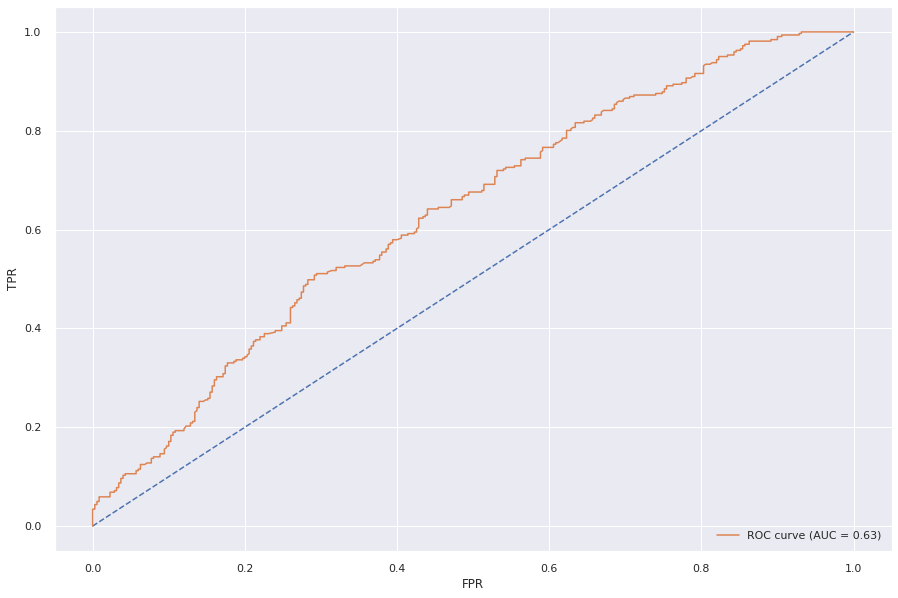

In [ ]:
# calculate scores
auc = roc_auc_score(y_test, predictions)

# calculate roc curves
fpr, tpr, _ = roc_curve(y_test, predictions)

plt.figure(figsize=(15, 10))
# plot horizontal line 
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc)
# axis labels
plt.xlabel('FPR')
plt.ylabel('TPR')
# show the legend
plt.legend(loc='lower right')
# show the plot
plt.show()

## Feature Importance

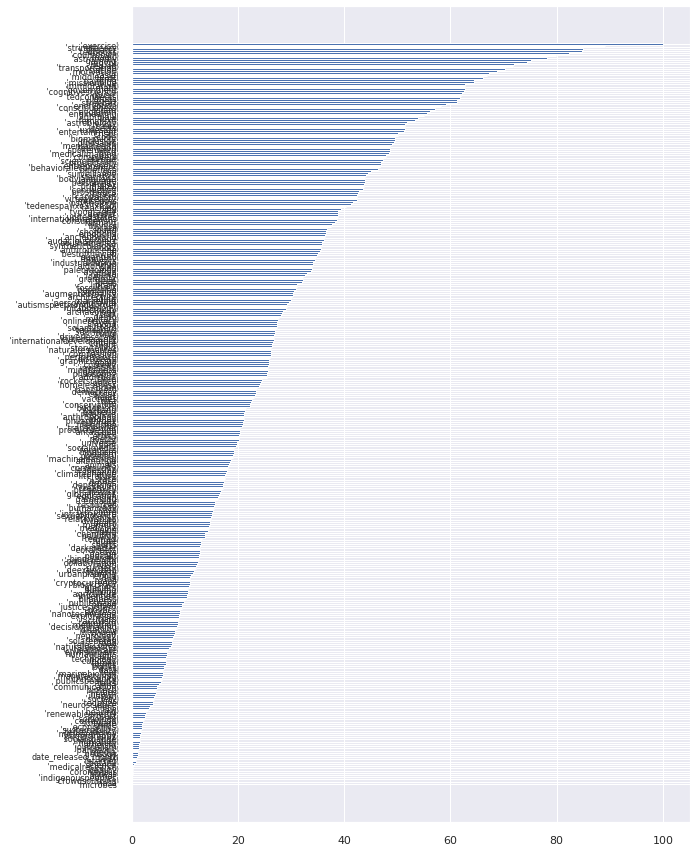

In [ ]:
feature_importance = abs(clf.coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure(figsize=(10, 15))
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(X.columns)[sorted_idx], fontsize=8)

plt.show()

In [117]:
# NLP Machine Learning on Description
#Spacy to capture entities from description

In [136]:
import spacy
from spacy import displacy


text=df.description_1[0]

nlp = spacy.load("en_core_web_sm")
doc = nlp(text)
displacy.render(doc, style='ent', jupyter=True)


list_text = []
list_ent = []

for ent in doc.ents:
    print(ent.text, ent.label_)
    list_text.append(ent.text)
    list_ent.append(ent.label_)
    

test_df = pd.DataFrame(list_text, columns=['text'])
test_df['ent'] = list_ent
test_df

print(text)
print(test_df)

Ozawa Bineshi Albert PERSON
US GPE
Minnesota GPE
Arizona GPE
"We can't rely on those who created climate change to fix it, says climate justice organizer Ozawa Bineshi Albert. An Indigenous woman living in the heart of oil and gas country in the US, she's observed an alarming disconnect between empty promises made by corporations and the actual needs of communities on the ground. In this call for urgency and a shift in values, she advocates for climate policy to center frontline leaders and outlines some grassroots-led projects -- from water protection efforts in Minnesota to off-grid solar power in Arizona -- that have already sparked real change." pro
                   text     ent
0  Ozawa Bineshi Albert  PERSON
1                    US     GPE
2             Minnesota     GPE
3               Arizona     GPE
